<a href="https://colab.research.google.com/github/ssunggun2/2022_dacon_NLI/blob/main/Dacon_NLI_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인스톨

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 63.1 MB/s 
     |████████████████████████████████| 448 kB 57.8 MB/s 


# 구글 코랩 마운트

In [3]:
from google import colab
colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 패키지 불러오기 및 폰트 설정

In [4]:
import os
import pandas as pd
from zipfile import ZipFile
from google.colab import data_table
from glob import glob
import numpy as np
from tqdm import tqdm, tqdm_notebook

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

data_table.enable_dataframe_formatter()

In [5]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


# 자료 불러오기

In [6]:
zip_dir = '/content/drive/MyDrive/화요일 스터디 폴더/dacon'
zip_name = 'open.zip'
zip_fPath = os.path.join(zip_dir, zip_name)

with ZipFile(zip_fPath, 'r') as zip:
    zip.printdir()
    zip.extractall() 

File Name                                             Modified             Size
open/sample_submission.csv                     2022-01-25 15:19:44        18894
open/test_data.csv                             2022-01-25 15:19:46       320363
open/train_data.csv                            2022-01-25 17:30:34      4855176


In [7]:
train = pd.read_csv('/content/open/train_data.csv')
test = pd.read_csv('/content/open/test_data.csv')
submission = pd.read_csv('/content/open/sample_submission.csv')
train.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [8]:
print(f"train_shape : {train.shape}")
print(f"test_shape : {test.shape}")
print(f"submission_shape : {submission.shape}")

train_shape : (24998, 4)
test_shape : (1666, 4)
submission_shape : (1666, 2)


# 데이터 시각화

## train target 분포 확인

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


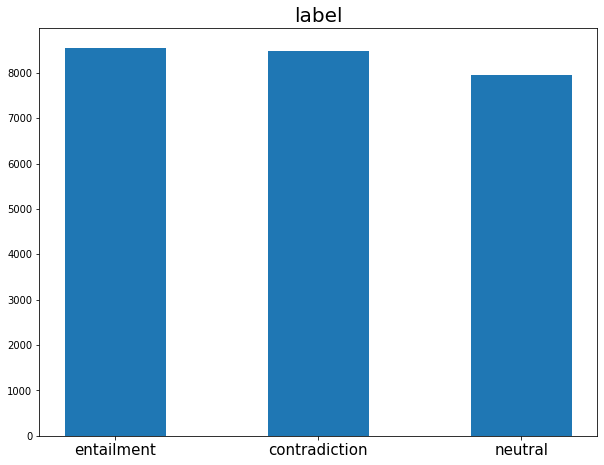

In [9]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅시다
feature = train["label"]

plt.figure(figsize = (10,7.5)) # 그래프 이미지 크기 설정

plt.title('label', fontsize = 20)
temp = feature.value_counts()  # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize = 15)
plt.show()

## 실제 Text와 가설 Text의 평균 길이

In [10]:
premise_len_mean = np.mean(train['premise'].str.len())  # 리뷰 길이의 평균값 계산
print('실제 Text 평균 길이 :', premise_len_mean)

hypo_len_mean = np.mean(train['hypothesis'].str.len())  # 리뷰 길이의 평균값 계산
print('실제 Text 평균 길이 :', hypo_len_mean)

실제 Text 평균 길이 : 45.406552524201935
실제 Text 평균 길이 : 24.924433954716378


In [32]:
# 데이터 필터링을 위한 마스크 설정 (premise 부분만)
mask_true = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train_pre = train.premise.copy()

df_true = train.loc[mask_true,:].premise 
df_false = train.loc[mask_false,:].premise 
df_neu = train.loc[mask_neutral,:].premise 

# 세 집합을 리스트로 묶어줍니다.
compare = [df_train_pre, df_true, df_false, df_neu]

In [27]:
df_true.head()

2                       이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.
5     이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...
10                       대부분 도보로 이동하기 충분하다는 점이 매력적이었어요.
12                          영화 시작부터 끝까지 긴장감을 늦출 수가 없네요.
16    국토교통부는 연료보조금 지급 근거를 마련하기 위해 올해 하반기에 여객자동차 및 화물...
Name: premise, dtype: object

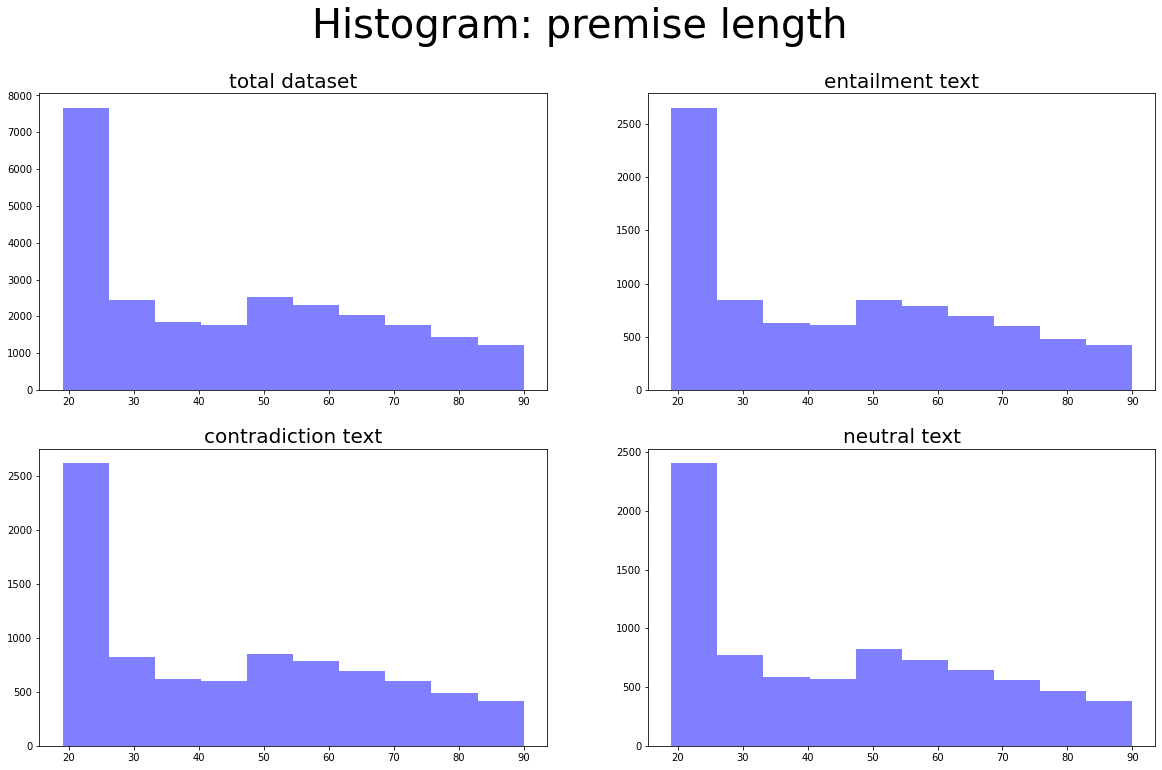

In [31]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize = (20,12))
plt.suptitle("Histogram: premise length", fontsize=40)
name = ['total dataset', 'entailment text' , 'contradiction text', 'neutral text']
for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]
    # print(string_len)
    plt.subplot(2,2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len , alpha = 0.5, color = 'b')
plt.show()


In [33]:
mask_ture = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train_hypo = train.hypothesis.copy()

df_true_hypo = train.loc[mask_ture,:].hypothesis
df_false_hypo = train.loc[mask_ture,:].hypothesis
df_neu_hypo = train.loc[mask_ture,:].hypothesis

# 세 집합을 리스트로 묶어줍니다.
compare_hypo = [df_train_hypo, df_true_hypo, df_false_hypo, df_neu_hypo]

In [34]:
df_true_hypo.head()

2     예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.
5         코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.
10                            대부분 걸어서 갈수 있어요.
12                        영화 시작부터 긴장감이 함께하네요.
16      여객자동차 및 화물자동차 운수사업법을 국토교통부가 개정할 계획이다.
Name: hypothesis, dtype: object

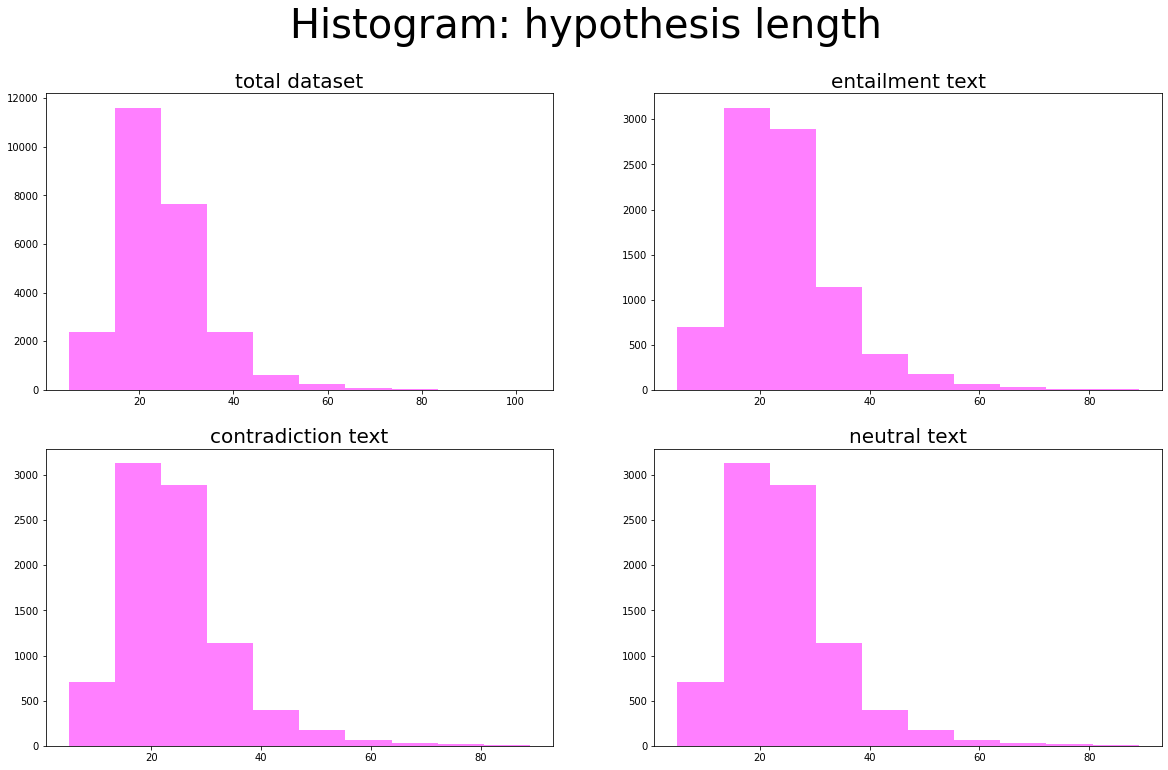

In [36]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: hypothesis length", fontsize=40)
name = ['total dataset', 'entailment text', 'contradiction text', 'neutral text']

for i in range(len(compare)):
    document = compare_hypo[i]
    string_len = [len(x) for x in document] 
    plt.subplot(2, 2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='magenta') 
    
plt.show()

In [37]:
def df2str(array):  # input = array
    # 전체 리뷰들을 하나의 문자열로 만듦
    s = [s for s in array]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

In [53]:
def get_noun(text):
    # okt tagger를 이용해 명사 추출
    okt = Okt()
    noun = okt.nouns(text) # output = list
    for i, v in enumerate(noun):
        if len(v) < 2:
            noun.pop(i)
    count = Counter(noun)
    # 빈도수 상위 100개
    noun_list = count.most_common(100)
    return noun_list

In [54]:
def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        font_path = font_path,
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인

In [55]:
document_pre = df2str(train.premise) # 전체 리뷰들을 하나의 문자열로 만듦
pre_noun_list = get_noun(document_pre) # 명사 추출, 개수 셈
pre_noun_list[:10] 

[('영화', 2265),
 ('위해', 922),
 ('숙소', 900),
 ('위치', 701),
 ('대한', 676),
 ('사업', 670),
 ('정말', 659),
 ('지역', 602),
 ('지원', 581),
 ('통해', 565)]

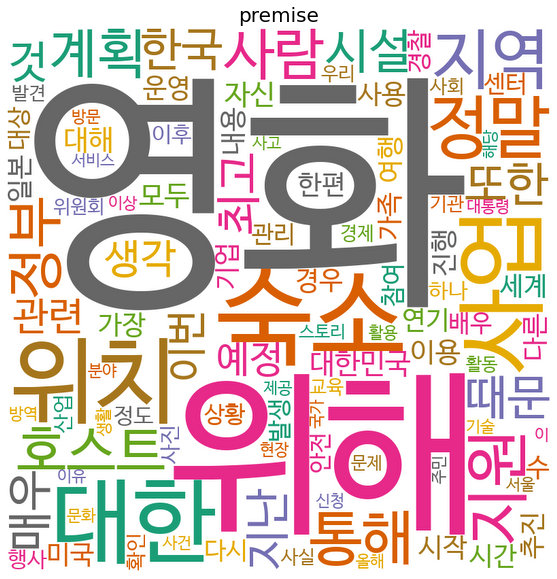

In [58]:
premis_text = visualize(pre_noun_list,'premise') # 워드클라우드 시각화

In [56]:
document_hypo = df2str(train.hypothesis) # 전체 리뷰들을 하나의 문자열로 만듦
hypo_noun_list = get_noun(document_hypo) # 명사 추출, 개수 셈
hypo_noun_list[:10]

[('영화', 2053),
 ('숙소', 713),
 ('사람', 539),
 ('호스트', 443),
 ('위치', 421),
 ('사업', 401),
 ('대한', 342),
 ('가장', 336),
 ('지원', 328),
 ('예정', 316)]

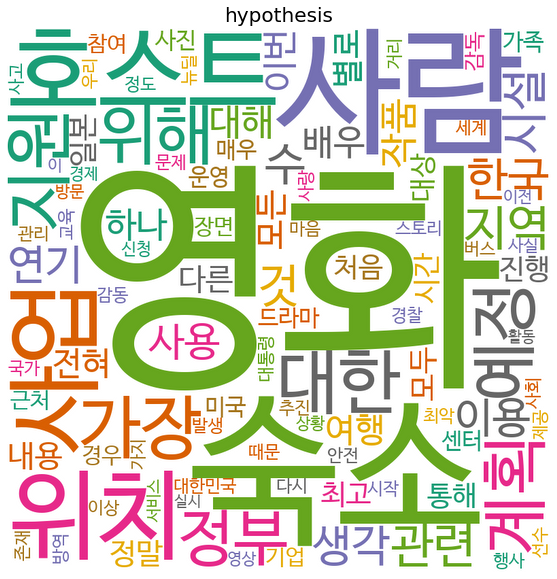

In [57]:
hypothesis_text = visualize(hypo_noun_list,'hypothesis') # 워드클라우드 시각화